In [8]:
import pandas as pd
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import ast
import re

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
import tensorflow as tf

# GPU 사용 설정
device_name = tf.test.gpu_device_name()
if not tf.config.list_physical_devices('GPU'):
    print("GPU를 찾을 수 없습니다. 런타임 유형을 GPU로 변경해주세요.")
else:
    print(f"GPU 장치: {device_name}")

GPU 장치: /device:GPU:0


2023-12-07 16:14:00.754865: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2023-12-07 16:14:00.754891: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2023-12-07 16:14:00.754899: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2023-12-07 16:14:00.755292: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-07 16:14:00.755823: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# 1. 연차별 전처리
- 출시일을 기준으로 1~4개년으로 나누는 전처리 수행

In [3]:
data = pickle.load(open('감성분석결과_최종_데이터프레임.pkl', 'rb'))
data.head(3)

,id,model,date,rating,sentence,atepc_aspect,apc_aspect,feature,main_feature,sentiment,...,main_n,bat_yn,dis_yn,cam_yn,body_yn,func_yn,proc_yn,stor_yn,acc_yn,main_yn
0,1,galaxy_s3,2012-05-11,2,too plasticky for $ 700 . When I put a review ...,[materials],[quality materials],[qualiti_materi],[body],[Negative],...,0,0,0,0,1,0,0,0,0,0
1,2,galaxy_s3,2012-06-01,5,So far super good . I got my S3 in white yeste...,"[memory, battery, battery life]","[memory, battery, battery life]","[memori, batteri, batteri_life]","[stor, bat, bat]","[Neutral, Positive, Positive]",...,0,1,0,0,0,0,0,1,0,1
2,3,galaxy_s3,2012-06-01,2,Expensive or Respect . i ' ve narrowed my choi...,[],"[16gb, of storage, 32gb, 16gb, 32gb]","[16gb, storag, 32gb, 16gb, 32gb]","[stor, stor, stor, stor, stor]","[Negative, Negative, Negative, Positive, Posit...",...,1,0,0,0,0,0,0,1,0,1


In [4]:
df_m = data.copy()
df_m['date'] = pd.to_datetime(df_m['date'])
df_m['date_y'] = df_m['date'].dt.strftime('%Y')
df_m['date_ym'] = df_m['date'].dt.strftime('%Y-%m')

In [5]:
df_group_ym = df_m.groupby(['model', 'date_ym']).size().reset_index(name='count')
list_x_ym = list(df_group_ym.sort_values(by='date_ym')['date_ym'].unique())

In [6]:
df_group_ym.head()

,model,date_ym,count
0,galaxy_s10e,2019-08,5
1,galaxy_s10e,2019-09,9
2,galaxy_s10e,2019-10,15
3,galaxy_s10e,2019-11,29
4,galaxy_s10e,2019-12,71


In [7]:
df_rel = pd.read_excel('/Users/sonjiyeong/Documents/랩실 프로젝트/스마트폰/data/record data/출시일.xlsx')
df_rel = df_rel[['model', 'release_date', 'last_reviewdate']].rename(columns={'release_date':'min', 
                                                                             'last_reviewdate':'max'})

df_rel['min'] = df_rel['min'].dt.to_period('M')
df_rel['max'] = df_rel['max'].dt.to_period('M')
df_rel.set_index('model', inplace=True)
min_max_by_model = df_rel.copy()

In [8]:
min_max_by_model.head()

,min,max
model,,
iphone6s,2015-09,2019-09
galaxy_s5,2014-03,2018-03
iphone7,2016-09,2020-02
galaxy_s7,2016-03,2020-02
iphone_5s,2013-09,2018-05


In [9]:
all_months_by_model = {}
for model, (min_date, max_date) in min_max_by_model.iterrows():
    min_date = pd.to_datetime(str(min_date))
    max_date = pd.to_datetime(str(max_date))
    all_months_by_model[model] = pd.date_range(start=min_date, end=max_date, freq='MS').strftime('%Y-%m')

# 각 모델별로 새로운 행 생성
new_rows = []
for model, all_months in all_months_by_model.items():
    existing_months = set(df_group_ym[df_group_ym['model'] == model]['date_ym'])
    missing_months = set(all_months) - existing_months
    for missing_month in missing_months:
        new_rows.append({'model': model, 'date_ym': missing_month, 'count': 0})

# 새로운 행을 데이터프레임에 추가
new_df = pd.concat([df_group_ym] + [pd.DataFrame([row]) for row in new_rows], ignore_index=True)

In [10]:
df_group_ym_new = new_df.sort_values(by=['model', 'date_ym'])
df_group_ym_new['date_ym'] = pd.to_datetime(df_group_ym_new['date_ym'])

df_group_ym_new['period'] = df_group_ym_new.groupby('model')['date_ym'].cumcount() // 12 + 1
df_dummy = df_group_ym_new.copy()
df_group_ym_new['date_ym'] = df_group_ym_new['date_ym'].dt.strftime('%Y-%m')
df_group_ym_new = df_group_ym_new[['model', 'date_ym', 'period']]
df_group_ym_new.head()

,model,date_ym,period
768,galaxy_s10e,2019-03,1
770,galaxy_s10e,2019-04,1
769,galaxy_s10e,2019-05,1
767,galaxy_s10e,2019-06,1
771,galaxy_s10e,2019-07,1


In [11]:
df_peri_cnt = df_dummy.groupby(['model', 'period']).agg({'count':'sum'}).reset_index()
df_peri_cnt.head()

,model,period,count
0,galaxy_s10e,1,264
1,galaxy_s10e,2,544
2,galaxy_s10e,3,785
3,galaxy_s10e,4,848
4,galaxy_s10e,5,199


In [12]:
df_m_new = pd.merge(df_m, df_group_ym_new, how='left', on=['model', 'date_ym'])
df_m_new['period'] = df_m_new['period'].astype(str)
list_x_period = list(df_m_new.sort_values(by='period')['period'].unique())
df_m_new.head(3)

,id,model,date,rating,sentence,atepc_aspect,apc_aspect,feature,main_feature,sentiment,...,cam_yn,body_yn,func_yn,proc_yn,stor_yn,acc_yn,main_yn,date_y,date_ym,period
0,1,galaxy_s3,2012-05-11,2,too plasticky for $ 700 . When I put a review ...,[materials],[quality materials],[qualiti_materi],[body],[Negative],...,0,1,0,0,0,0,0,2012,2012-05,1
1,2,galaxy_s3,2012-06-01,5,So far super good . I got my S3 in white yeste...,"[memory, battery, battery life]","[memory, battery, battery life]","[memori, batteri, batteri_life]","[stor, bat, bat]","[Neutral, Positive, Positive]",...,0,0,0,0,1,0,1,2012,2012-06,1
2,3,galaxy_s3,2012-06-01,2,Expensive or Respect . i ' ve narrowed my choi...,[],"[16gb, of storage, 32gb, 16gb, 32gb]","[16gb, storag, 32gb, 16gb, 32gb]","[stor, stor, stor, stor, stor]","[Negative, Negative, Negative, Positive, Posit...",...,0,0,0,0,1,0,1,2012,2012-06,1


## 모델별, 연차별 리뷰 개수 시각화 

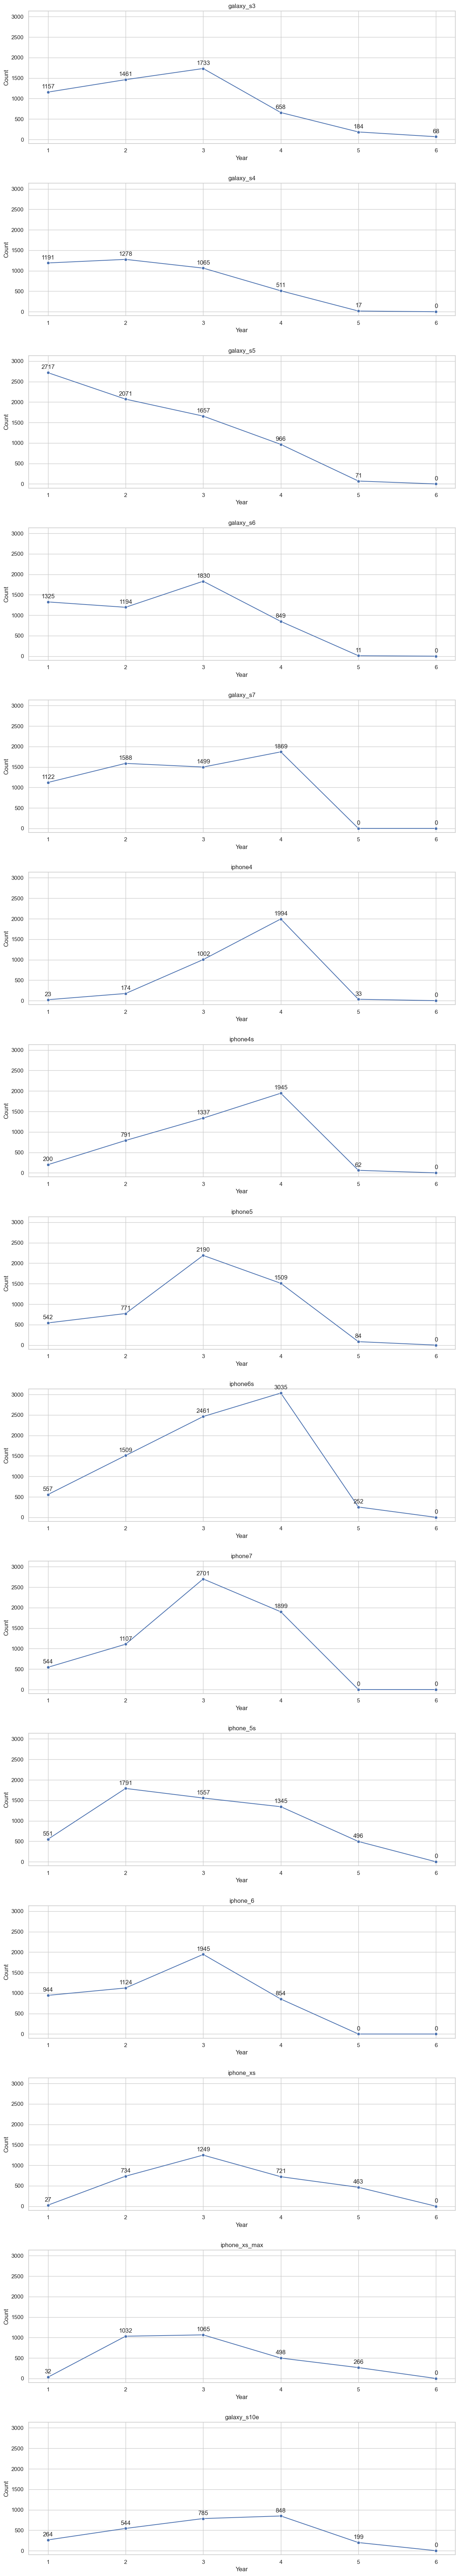

In [26]:
# 그래프 스타일 설정
sns.set(style="whitegrid")

# 모델별로 그래프 그리기
models = df_m_new['model'].unique()
num_models = len(models)

# 서브플롯 설정
fig, axes = plt.subplots(nrows=num_models, figsize=(15, 6*num_models), sharex=False,
                         gridspec_kw={'hspace': 0.3})  # hspace를 조정하여 그래프 간격 설정

# 각 모델별로 그래프 그리기
for i, model in enumerate(models):
    ax = axes[i]
    data = df_m_new[df_m_new['model'] == model]
    
    # 각 연도별 데이터 개수 구하기
    data_count = data.groupby('period').size()
    data_count = data_count.reindex(list_x_period, fill_value=0)
    sns.lineplot(data=data_count.reset_index(), x='period', y=0, marker='o', ax=ax)
    ax.set_title(model)
    ax.set_ylabel('Count')
    ax.set_xlabel('Year')

    # x축에 표시할 값 설정
    ax.set_xticks(list_x_period)
    ax.set_xticklabels(list_x_period) #, rotation=45)  # 눈금 레이블 회전
    
    # y축 범위 설정
    ax.set_ylim(-100, max(df_peri_cnt['count']) + 100) 

    # 각 데이터 포인트 위에 값 표시
    for index, value in data_count.items():
        ax.annotate(str(value), xy=(index, value), xytext=(0, 5), textcoords='offset points',
                    ha='center', va='bottom')

# 그래프 보이기
plt.show()

In [27]:
data = df_m_new.drop(['date_y', 'date_ym'], axis=1)

In [29]:
import pickle
file_name = '최종_period_데이터프레임.pkl'

with open(file_name, 'wb') as file:
    pickle.dump(data, file)
    
data.to_csv('최종_period_데이터프레임.csv', index=False)

# 2. 모델별, 연차별, 속성별 전처리

In [5]:
model_list = ['iphone4', 
                'iphone4s',
                'galaxy_s3',
                'iphone5',
                'galaxy_s4',
                'iphone_5s',
                'galaxy_s5',
                'iphone_6',
                'galaxy_s6',
                'iphone6s',
                'galaxy_s7',
                'iphone7',
                'iphone_xs',
                'iphone_xs_max',
                'galaxy_s10e']

order_list = list(range(1,16))

# 출시일 순서
df_order = pd.DataFrame({'model':model_list, 'order':order_list}) 
df_order.head()

,model,order
0,iphone4,1
1,iphone4s,2
2,galaxy_s3,3
3,iphone5,4
4,galaxy_s4,5


In [6]:
# period 열이 추가된 데이터프레임
data = pickle.load(open('최종_period_데이터프레임.pkl', 'rb'))
data = pd.merge(data, df_order, on='model') # 출시일 순서 결합
print('데이터 개수:', data.shape[0])
data.head(2)

데이터 개수: 74148


,id,model,date,rating,sentence,atepc_aspect,apc_aspect,feature,main_feature,sentiment,...,dis_yn,cam_yn,body_yn,func_yn,proc_yn,stor_yn,acc_yn,main_yn,period,order
0,1,galaxy_s3,2012-05-11,2,too plasticky for $ 700 . When I put a review ...,[materials],[quality materials],[qualiti_materi],[body],[Negative],...,0,0,1,0,0,0,0,0,1,3
1,2,galaxy_s3,2012-06-01,5,So far super good . I got my S3 in white yeste...,"[memory, battery, battery life]","[memory, battery, battery life]","[memori, batteri, batteri_life]","[stor, bat, bat]","[Neutral, Positive, Positive]",...,0,0,0,0,0,1,0,1,1,3


In [13]:
data['period'] = data['period'].apply(lambda x: int(x))
data[data['period']<4].groupby('model')['id'].count()

model
galaxy_s10e      1593
galaxy_s3        4351
galaxy_s4        3534
galaxy_s5        6445
galaxy_s6        4349
galaxy_s7        4209
iphone4          1199
iphone4s         2328
iphone5          3503
iphone6s         4527
iphone7          4352
iphone_5s        3899
iphone_6         4013
iphone_xs        2010
iphone_xs_max    2129
Name: id, dtype: int64

In [6]:
lst_yn = ['bat_yn', 'dis_yn', 'cam_yn', 'body_yn', 'func_yn', 'proc_yn', 'stor_yn', 'acc_yn', 'main_yn']
lst_p = ['bat_p', 'dis_p', 'cam_p', 'body_p', 'func_p', 'proc_p', 'stor_p', 'acc_p', 'main_p']
lst_n = ['bat_n', 'dis_n', 'cam_n', 'body_n', 'func_n', 'proc_n', 'stor_n', 'acc_n', 'main_n']

In [7]:
df = data.groupby(['order', 'model', 'period']).agg({'id':'size', 
                                       'bat_yn':'sum', 'dis_yn':'sum', 'cam_yn':'sum',
                                      'body_yn':'sum', 'func_yn':'sum', 'proc_yn':'sum', 
                                      'stor_yn':'sum', 'acc_yn':'sum', 'main_yn':'sum',
                                               
                                       'bat_p':'sum', 'dis_p':'sum', 'cam_p':'sum',
                                      'body_p':'sum', 'func_p':'sum', 'proc_p':'sum', 
                                      'stor_p':'sum', 'acc_p':'sum', 'main_p':'sum',  
                                               
                                       'bat_n':'sum', 'dis_n':'sum', 'cam_n':'sum',
                                      'body_n':'sum', 'func_n':'sum', 'proc_n':'sum', 
                                      'stor_n':'sum', 'acc_n':'sum', 'main_n':'sum',  
                                                     
                                       'bat_m':'sum', 'dis_m':'sum', 'cam_m':'sum',
                                      'body_m':'sum', 'func_m':'sum', 'proc_m':'sum', 
                                      'stor_m':'sum', 'acc_m':'sum', 'main_m':'sum',  
                                                                                                    
                                      }).rename(columns={'id':'count'}).reset_index()

df['period'] = df['period'].astype('int')
df = df.drop('order', axis=1) # order열 (순서정보) 제거 - 필요없기 때문에
df = df[df['period']<5]

In [ ]:
df.to_csv('모델별연차별_속성횟수.csv', index=False)

In [7]:
df = np.transpose(df).reset_index() #drop=False)
df.head()

,index,0,1,2,3,5,6,7,8,10,...,60,61,63,64,65,66,68,69,70,71
0,model,iphone4,iphone4,iphone4,iphone4,iphone4s,iphone4s,iphone4s,iphone4s,galaxy_s3,...,iphone_xs,iphone_xs,iphone_xs_max,iphone_xs_max,iphone_xs_max,iphone_xs_max,galaxy_s10e,galaxy_s10e,galaxy_s10e,galaxy_s10e
1,period,1,2,3,4,1,2,3,4,1,...,3,4,1,2,3,4,1,2,3,4
2,count,23,174,1002,1994,200,791,1337,1945,1157,...,1249,721,32,1032,1065,498,264,544,785,848
3,bat_yn,3,17,55,105,28,54,122,227,240,...,403,278,5,253,257,145,39,108,198,188
4,dis_yn,8,26,67,173,26,56,78,75,385,...,241,150,5,133,174,89,25,71,85,94


In [8]:
df

,index,0,1,2,3,5,6,7,8,10,...,60,61,63,64,65,66,68,69,70,71
0,model,iphone4,iphone4,iphone4,iphone4,iphone4s,iphone4s,iphone4s,iphone4s,galaxy_s3,...,iphone_xs,iphone_xs,iphone_xs_max,iphone_xs_max,iphone_xs_max,iphone_xs_max,galaxy_s10e,galaxy_s10e,galaxy_s10e,galaxy_s10e
1,period,1,2,3,4,1,2,3,4,1,...,3,4,1,2,3,4,1,2,3,4
2,count,23,174,1002,1994,200,791,1337,1945,1157,...,1249,721,32,1032,1065,498,264,544,785,848
3,bat_yn,3,17,55,105,28,54,122,227,240,...,403,278,5,253,257,145,39,108,198,188
4,dis_yn,8,26,67,173,26,56,78,75,385,...,241,150,5,133,174,89,25,71,85,94
5,cam_yn,6,26,50,70,24,39,55,28,166,...,74,40,4,60,59,26,18,56,72,75
6,body_yn,9,40,248,490,36,165,231,201,324,...,357,204,7,337,280,128,81,172,216,203
7,func_yn,5,21,103,198,27,62,135,117,211,...,213,115,6,119,155,71,33,77,129,107
8,proc_yn,0,5,7,8,4,3,3,4,105,...,2,4,0,0,1,1,5,10,11,11
9,stor_yn,2,16,82,147,23,63,62,52,90,...,19,7,0,32,19,5,9,31,36,46


In [9]:
df.to_csv('모델별_속성별_언급횟수_중립포함.csv', index=False)

## 출시 순서 포함

In [7]:
data = pd.read_csv('모델별연차별_속성횟수.csv')
data.head()
data.shape

,model,period,count,bat_yn,dis_yn,cam_yn,body_yn,func_yn,proc_yn,stor_yn,...,main_n,bat_m,dis_m,cam_m,body_m,func_m,proc_m,stor_m,acc_m,main_m
0,iphone4,1,23,3,8,6,9,5,0,2,...,1,0,0,0,5,1,0,1,0,1
1,iphone4,2,174,17,26,26,40,21,5,16,...,8,0,1,2,5,2,1,2,6,3
2,iphone4,3,1002,55,67,50,248,103,7,82,...,28,2,7,6,11,6,1,22,13,23
3,iphone4,4,1994,105,173,70,490,198,8,147,...,63,2,14,0,16,9,0,45,27,46
4,iphone4s,1,200,28,26,24,36,27,4,23,...,7,2,4,5,6,5,0,8,7,8


(60, 39)

In [9]:
# 출시 순서 표시
lst_model = ['iphone4s',
            'galaxy_s3',
            'iphone5',
            'galaxy_s4',
            'iphone_5s',
            'galaxy_s5',
            'iphone_6',
            'galaxy_s6',
            'iphone6s',
            'galaxy_s7',
            'iphone7',
            'galaxy_s10e'] # 출시 순서별로

lst_order = list(range(1, len(lst_model)+1))

df_order = pd.DataFrame({'model':lst_model, 'rel_ord':lst_order}) 
df_order.head()

,model,rel_ord
0,iphone4s,1
1,galaxy_s3,2
2,iphone5,3
3,galaxy_s4,4
4,iphone_5s,5


In [10]:
df = pd.merge(df_order, data, on='model')
df.head()
df.shape

,model,rel_ord,period,count,bat_yn,dis_yn,cam_yn,body_yn,func_yn,proc_yn,...,main_n,bat_m,dis_m,cam_m,body_m,func_m,proc_m,stor_m,acc_m,main_m
0,iphone4s,1,1,200,28,26,24,36,27,4,...,7,2,4,5,6,5,0,8,7,8
1,iphone4s,1,2,791,54,56,39,165,62,3,...,21,1,3,2,9,3,0,18,10,18
2,iphone4s,1,3,1337,122,78,55,231,135,3,...,28,3,2,3,4,4,0,9,10,9
3,iphone4s,1,4,1945,227,75,28,201,117,4,...,20,7,9,4,10,5,0,10,13,10
4,galaxy_s3,2,1,1157,240,385,166,324,211,105,...,66,13,15,12,23,17,18,23,16,37


(48, 40)

In [11]:
df.to_csv('전체_모델속성별_횟수.csv', index=False)

# 3. 검토 파일 생성

## 검토 1

In [ ]:
df_ran = pd.read_csv('/Users/sonjiyeong/Documents/랩실 프로젝트/스마트폰/data/검증/랜덤추출_최종속성_검토.csv')
df_ran = df_ran[['sentence', 'sort_result']].rename(columns={'sort_result':'과거'})

In [ ]:
df_aspect_ran = df_aspect_yn[['sentence', 'mark_sentence', 'sort_result']]

In [ ]:
df_ch = pd.merge(df_aspect_ran, df_ran, on='sentence', how='right')
df_ch.head()

In [ ]:
df_ch.to_csv('/Users/sonjiyeong/Documents/랩실 프로젝트/스마트폰/data/검증/랜덤추출_추가_속성추출_감성예측_검토.csv', index=False)

##  검토 2

In [ ]:
df_af = pickle.load(open('감성분석결과_최종_데이터프레임.pkl', 'rb'))

In [ ]:
df_af_ran = df_af[~((df_af['bat_yn']==0) & (df_af['dis_yn']==0) & (df_af['cam_yn']==0) &
                (df_af['body_yn']==0) & (df_af['func_yn']==0) & (df_af['proc_yn']==0) &
                (df_af['stor_yn']==0) & (df_af['acc_yn']==0) & (df_af['main_yn']==0))].sample(n=100)
df_af_ran = df_af_ran[['id', 'model', 'sentence', 'mark_sentence', 'sort_result']].rename(columns={'sort_result':'후_추출'})

In [ ]:
df_bf = pickle.load(open('최종데이터프레임_속성언급여부.pkl', 'rb'))
df_bf = df_bf[['id', 'sort_result']].rename(columns={'sort_result':'전_추출'})

In [ ]:
df_random = pd.merge(df_af_ran, df_bf, on='id', how='left')

In [ ]:
df_random

In [ ]:
df_random.to_csv('/Users/sonjiyeong/Documents/랩실 프로젝트/스마트폰/data/검증/랜덤추출_추가_속성추출_감성예측_검토_new.csv', index=False)

## 검토 3

In [ ]:
df_af = pickle.load(open('감성분석결과_최종_데이터프레임.pkl', 'rb'))
df_af_ran = df_af[~((df_af['bat_yn'] == 0) & (df_af['dis_yn'] == 0) & (df_af['cam_yn'] == 0) &
                    (df_af['body_yn'] == 0) & (df_af['func_yn'] == 0) & (df_af['proc_yn'] == 0) &
                    (df_af['stor_yn'] == 0) & (df_af['acc_yn'] == 0) & (df_af['main_yn'] == 0))].sample(n=100)

In [ ]:
df_af_ran = df_af_ran[['id', 'model', 'sentence', 'mark_sentence', 
                       'sort_result']].rename(columns={'sort_result': '후_추출'})
df_bf = pickle.load(open('최종데이터프레임_속성언급여부.pkl', 'rb'))

In [ ]:
df_bf = df_bf[['id', 'sort_result']].rename(columns={'sort_result': '전_추출'})
df_random = pd.merge(df_af_ran, df_bf, on='id', how='left')
df_random

In [ ]:
df_random.to_csv('/Users/sonjiyeong/Documents/랩실 프로젝트/스마트폰/data/검증/랜덤추출_감성예측_검토_1.csv',
                 index=False)

In [ ]:
df_random.to_csv('/Users/sonjiyeong/Documents/랩실 프로젝트/스마트폰/data/검증/랜덤추출_감성예측_검토_2.csv', index=False)